In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import umap
import seaborn as sns
from statannotations.Annotator import Annotator
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

### Import Data

In [24]:
# Expression Data
rna_seq = pd.read_csv("../Data/RNAseq.csv", index_col=0).T
dna_meth = pd.read_csv("../Data/DNAmethylation.csv", index_col=0).T

# Clusterring Data
clustered_df = pd.read_csv("../Data/encoded_dataframe_with_clusters.csv", index_col=0)
clustered_df.index = rna_seq.index

# Clinical Metadata
clinical = pd.read_csv("../Data/brca_tcga_clinical_data.tsv", sep="\t")
clinical = clinical[clinical['Patient ID'].isin(clustered_df.index)]
clinical = clinical.replace(["NaN"], np.nan)
clinical = clinical.dropna(axis=1, how='all')
clinical.index = clinical["Patient ID"]
clinical = clinical[~clinical.index.duplicated(keep='first')]
clinical = clinical.drop(columns=["Patient ID", "Study ID", "Sample ID"])
clinical["cluster"] = clustered_df["cluster"]

# UMAP Data
umap_2d = umap.UMAP(n_components=2, random_state=42)
df_2d = umap_2d.fit_transform(clustered_df.iloc[:,0:25])

clinical

/var/folders/rn/0g0m6xp56qnfhjn3kwfr9kdc0000gn/T/ipykernel_84333/2097723917.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical = clinical.replace(["NaN"], np.nan)
/Users/frankpolak/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,American Joint Committee on Cancer Tumor Stage Code,Brachytherapy first reference point administered total dose,Cancer Type,Cancer Type Detailed,Cent17 Copy Number,...,Staging System,Staging System.1,Surgery for positive margins,Surgery for positive margins other,Surgical procedure first,Tissue Source Site,TMB (nonsynonymous),Person Neoplasm Status,Vial number,cluster
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AALI,50.0,M0,N1a,Stage IIB,6th,T2,NaN,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,...,Sentinel lymph node biopsy plus axillary disse...,NaN,NaN,NaN,Lumpectomy,3C,NaN,TUMOR FREE,A,1
TCGA-3C-AALJ,62.0,M0,N1a,Stage IIB,7th,T2,NaN,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,...,NaN,NaN,NaN,NaN,Modified Radical Mastectomy,3C,NaN,TUMOR FREE,A,0
TCGA-3C-AALK,52.0,M0,N0 (i+),Stage IA,7th,T1c,NaN,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,...,Sentinel node biopsy alone,NaN,NaN,NaN,Simple Mastectomy,3C,NaN,TUMOR FREE,A,0
TCGA-A1-A0SF,54.0,M0,N0,Stage IIA,6th,T2,NaN,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,...,Sentinel lymph node biopsy plus axillary disse...,NaN,NaN,NaN,Modified Radical Mastectomy,A1,1.1,TUMOR FREE,A,1
TCGA-A1-A0SH,39.0,M0,N0 (i-),Stage IIA,6th,T2,NaN,Breast Cancer,Breast Invasive Ductal Carcinoma,1.8,...,Sentinel node biopsy alone,NaN,NaN,NaN,Lumpectomy,A1,2.4,TUMOR FREE,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-S3-AA17,64.0,cM0 (i+),N1mi,Stage IIB,7th,T2,CAP SCORING GUIDELINE 2010,Breast Cancer,Breast Invasive Ductal Carcinoma,35,...,Sentinel node biopsy alone,NaN,NaN,NaN,Simple Mastectomy,S3,NaN,TUMOR FREE,A,0
TCGA-UL-AAZ6,73.0,MX,N0,Stage IIA,7th,T2,NaN,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,...,NaN,NaN,NaN,NaN,NaN,UL,NaN,TUMOR FREE,A,0
TCGA-UU-A93S,63.0,M1,N3b,Stage IV,7th,T4d,NaN,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,...,No axillary staging,NaN,NaN,NaN,Modified Radical Mastectomy,UU,NaN,WITH TUMOR,A,1


### Visualise

#### UMAP

/Users/frankpolak/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


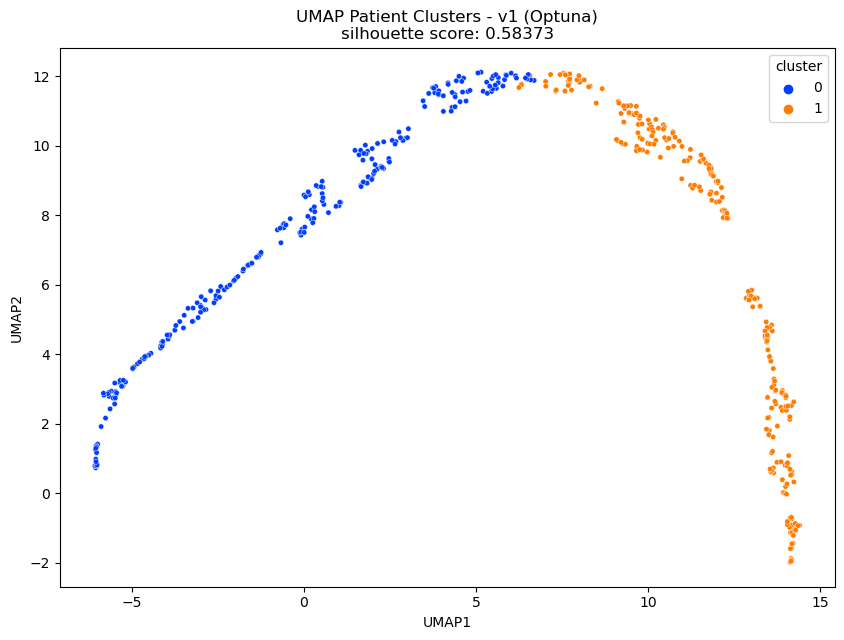

In [25]:
var_of_interest = "cluster"

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(clustered_df.drop("cluster", axis=1))

# Run UMAP on the scaled data
reducer = umap.UMAP(random_state=42)
df_2d = reducer.fit_transform(scaled_data)

# Create DataFrame for plotting
df_umap = pd.DataFrame(df_2d, columns=["UMAP1", "UMAP2"])
df_umap.index = clustered_df.index
df_umap["var"] = clinical[var_of_interest]

# Plot UMAP with cluster colors
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_umap["UMAP1"], y=df_umap["UMAP2"], hue=df_umap["var"], palette="bright", s=15)
plt.title("UMAP Patient Clusters - v1 (Optuna)\nsilhouette score: 0.58373")
plt.legend(title=var_of_interest)
plt.show()

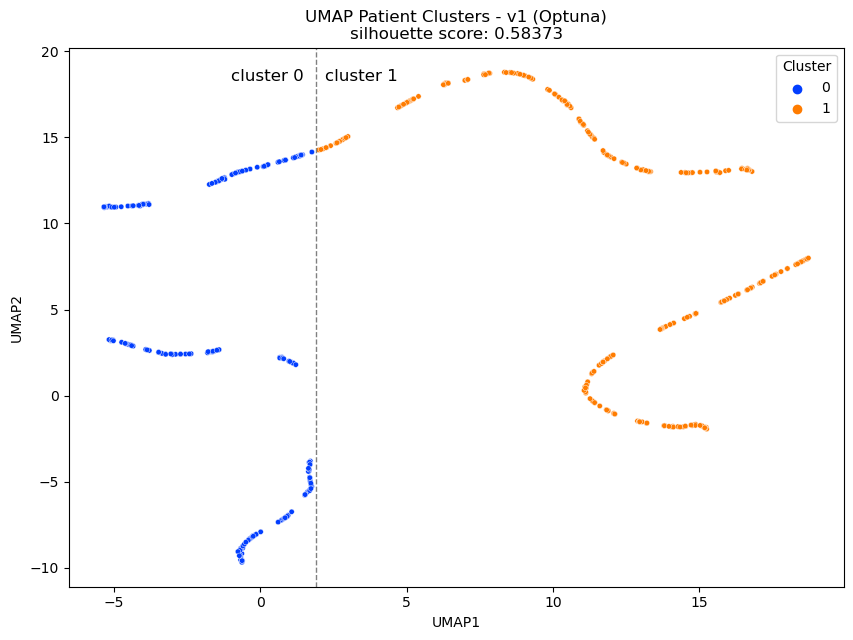

In [279]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_umap["UMAP1"], y=df_umap["UMAP2"], hue=df_umap["Cluster"], palette="bright", s=15)
plt.axvline(x=1.9, color='gray', linestyle='--', linewidth=1)

# Add cluster labels
plt.text(-1, df_umap["UMAP2"].max() - 0.5, "cluster 0", fontsize=12, color="black")
plt.text(2.2, df_umap["UMAP2"].max() - 0.5, "cluster 1", fontsize=12, color="black")

plt.title("UMAP Patient Clusters - v1 (Optuna)\nsilhouette score: 0.58373")
plt.legend(title="Cluster")
plt.show()


### tSNE

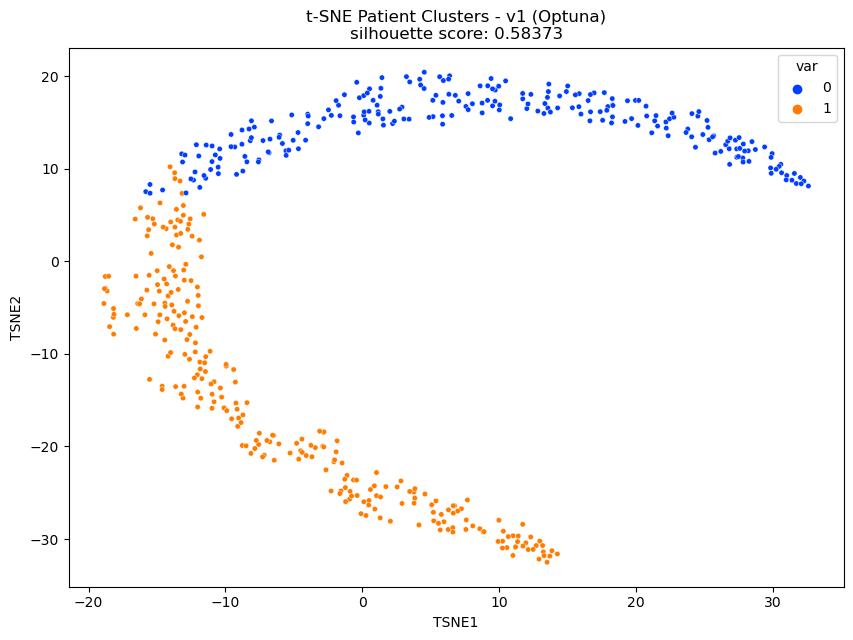

In [26]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(clustered_df.drop("cluster", axis=1))

# Run t-SNE on the scaled data
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
df_2d = tsne.fit_transform(scaled_data)

# Create DataFrame for plotting
df_tsne = pd.DataFrame(df_2d, columns=["TSNE1", "TSNE2"])
df_tsne.index = clustered_df.index
df_tsne["var"] = clinical["cluster"]

# Plot t-SNE with cluster colors
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_tsne["TSNE1"], y=df_tsne["TSNE2"], hue=df_tsne["var"], palette="bright", s=15)
plt.title("t-SNE Patient Clusters - v1 (Optuna)\nsilhouette score: 0.58373")
plt.legend(title="var")
plt.show()


# Survival Analysis

                                coef     exp(coef)  se(coef)  coef lower 95%  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z             p    -log2(p)
covariate                                                                                                                                                                          
Diagnosis Age               0.043501  1.044461e+00  0.027768       -0.010924        0.097926             0.989135         1.102882e+00     0.0   1.566564  1.172165e-01    3.092752
ER Status By IHC_Positive   0.398404  1.489446e+00  0.809137       -1.187476        1.984284             0.304990         7.273839e+00     0.0   0.492381  6.224498e-01    0.683971
PR status by ihc_Positive  -1.046237  3.512571e-01  0.081524       -1.206020       -0.886454             0.299386         4.121147e-01     0.0 -12.833546  1.063809e-37  122.822100
HER2 fish status_Negative  14.590660  2.170916e+06  1.006175       12.618593       16.562726        

/Users/frankpolak/anaconda3/lib/python3.11/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.549. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


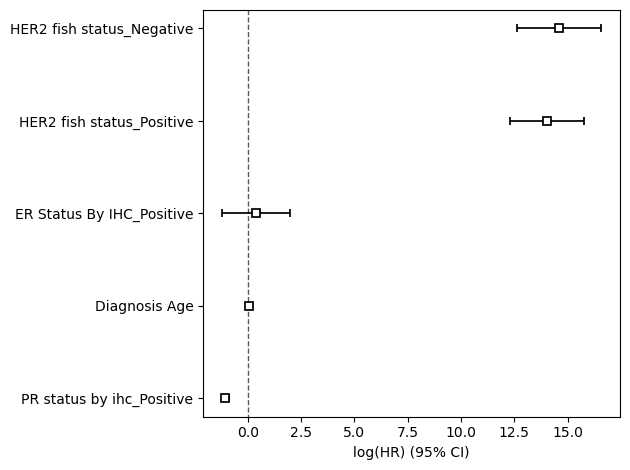

In [ ]:
duration_col = "Overall Survival (Months)"
event_col = "Overall Survival Status" 
cluster_col = "cluster"

clinical[event_col] = clinical[event_col].astype(str).str.extract(r"(\d)").astype(int)

covariates = [
    "Diagnosis Age",
    "ER Status By IHC",
    "PR status by ihc",
    "HER2 fish status"
]

# Keep only relevant columns
cols_to_use = [duration_col, event_col, cluster_col] + covariates
df_clean = clinical[cols_to_use].dropna()

# One-hot encode categorical variables
categorical_vars = ["ER Status By IHC", "PR status by ihc", "HER2 fish status"]
df_encoded = pd.get_dummies(df_clean, columns=categorical_vars, drop_first=True)

# Fit Cox Proportional Hazards Model with clustering
cph = CoxPHFitter()
cph.fit(df_encoded, duration_col=duration_col, event_col=event_col, cluster_col=cluster_col)

# Results
print(cph.summary.to_string())

# plot coefficients
cph.plot()
plt.tight_layout()
plt.show()


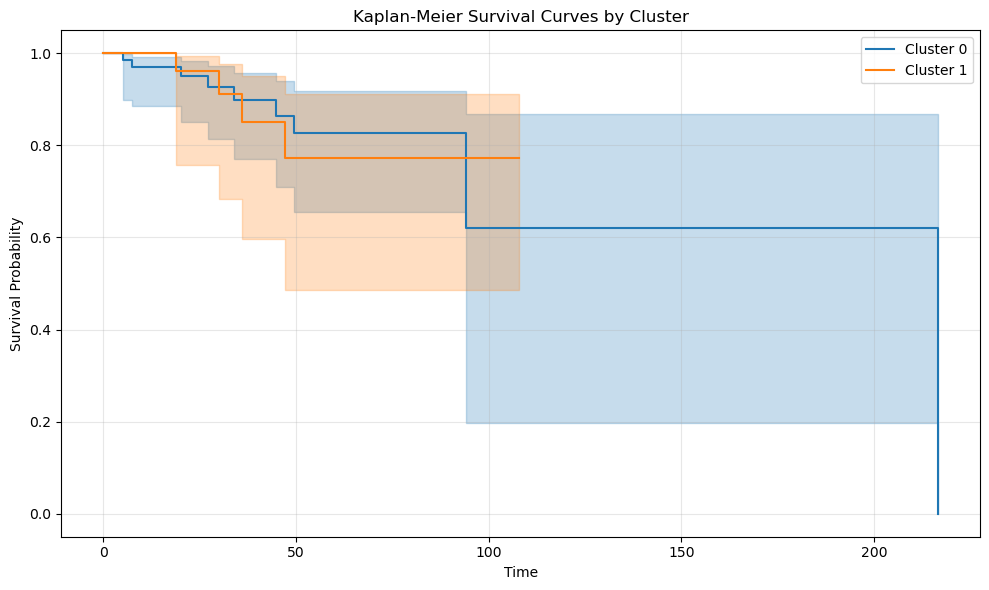

Cox Proportional Hazards Model Summary:
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
cluster   -0.187905   0.828694    0.2575       -0.692595        0.316786   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
cluster               0.500276             1.372708     0.0 -0.729727   

                  p  -log2(p)  
covariate                      
cluster    0.465557  1.102971  


In [35]:
# Initialize the figure
plt.figure(figsize=(10, 6))

# Create a Kaplan-Meier plot for each cluster
for cluster in [0, 1]:
    # Filter data for this cluster
    cluster_data = df_encoded[df_encoded['cluster'] == cluster]
    
    # Initialize the Kaplan-Meier fitter
    kmf = KaplanMeierFitter()
    
    # Fit the Kaplan-Meier estimator for this cluster
    kmf.fit(cluster_data[duration_col], 
            event_observed=cluster_data[event_col], 
            label=f'Cluster {cluster}')
    
    # Plot the survival function
    kmf.plot(ax=plt.gca())

# Add labels and title
plt.title('Kaplan-Meier Survival Curves by Cluster')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Cox Proportional Hazards Model
# Create a dataframe for the Cox model
cox_df = df_encoded[[duration_col, event_col, 'cluster']].copy()

# Initialize and fit the Cox model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col=duration_col, event_col=event_col)

# Print the summary
print("Cox Proportional Hazards Model Summary:")
print(cph.summary)

#### Boxplots

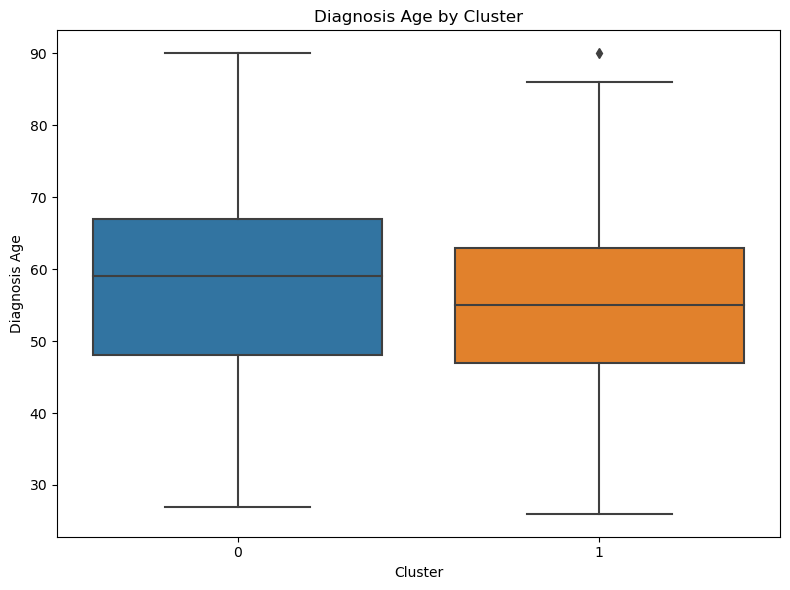

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(data=clinical, x='cluster', y='Diagnosis Age')

plt.title('Diagnosis Age by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Diagnosis Age')
plt.tight_layout()
plt.show()

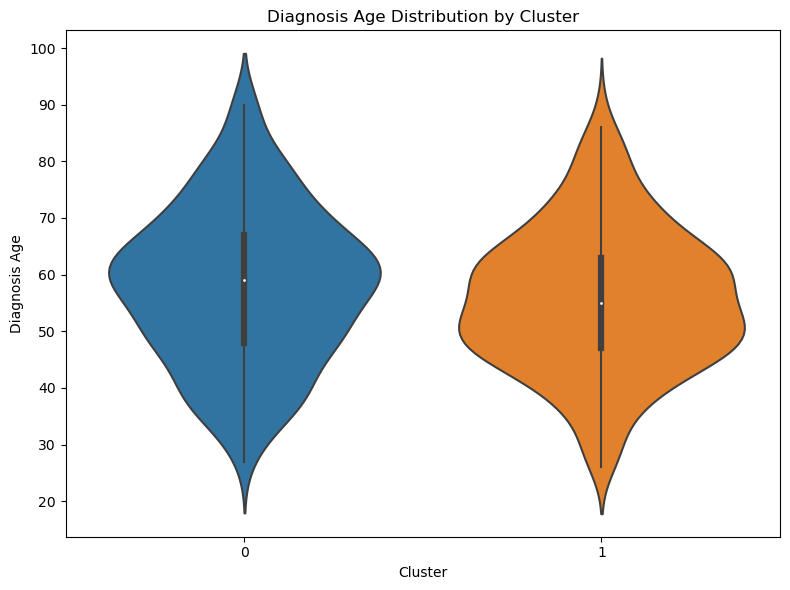

In [31]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=clinical, x='cluster', y='Diagnosis Age', inner='box')

plt.title('Diagnosis Age Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Diagnosis Age')
plt.tight_layout()
plt.show()


#### Histograms

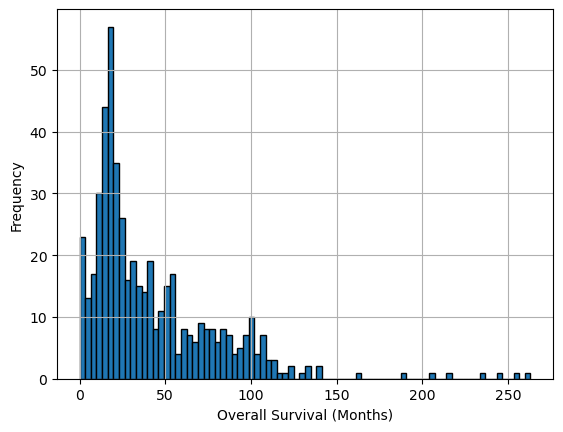

In [38]:
import matplotlib.pyplot as plt

# Filter the data
brca_age = clinical["Overall Survival (Months)"]

# Plot histogram
plt.hist(brca_age, bins=80, edgecolor='black')
plt.xlabel("Overall Survival (Months)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Contingency Tables

In [39]:
clinical["Cancer Type"].value_counts()

Cancer Type
Breast Cancer                510
Skin Cancer, Non-Melanoma      1
Name: count, dtype: int64

In [22]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(clinical['HER2 fish status'], clinical['cluster'])

# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p_value)

# Interpret the result
if p_value < 0.05:
    print("There is a statistically significant association between PR status and cluster.")
else:
    print("There is no statistically significant association between PR status and cluster.")


Chi-square statistic: 1.989273847135543
Degrees of freedom: 4
P-value: 0.737731838420397
There is no statistically significant association between PR status and cluster.


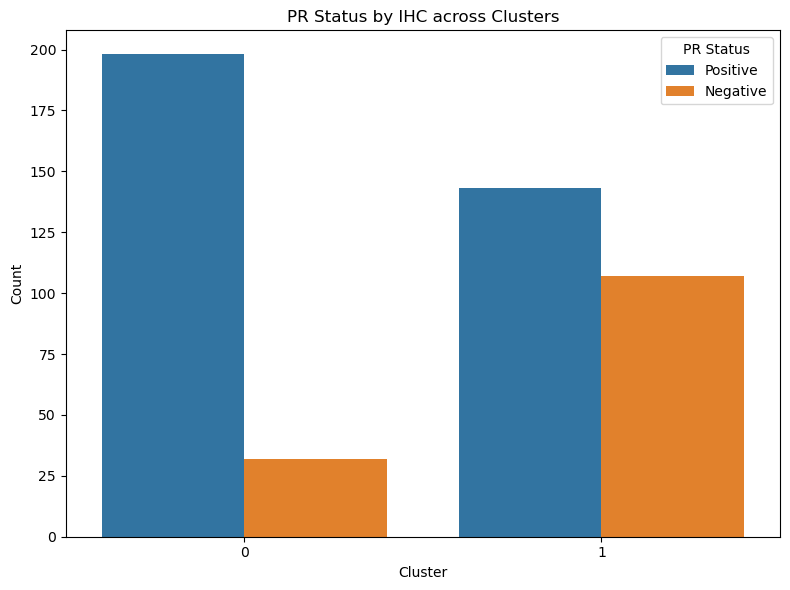

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot
plt.figure(figsize=(8, 6))
sns.countplot(data=clinical, x='cluster', hue='ER Status By IHC')

plt.title('PR Status by IHC across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='PR Status')
plt.tight_layout()
plt.show()


In [42]:
# Separate columns
numerical_cols = clinical.select_dtypes(include=['number']).columns.tolist()
categorical_cols = clinical.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Remove 'cluster' from the list if it's included
numerical_cols = [col for col in numerical_cols if col != 'cluster']
categorical_cols = [col for col in categorical_cols if col != 'cluster']


In [43]:
from scipy.stats import f_oneway, kruskal, chi2_contingency, fisher_exact
import pandas as pd

results = []

# Numerical Variables
for col in numerical_cols:
    groups = [group[col].dropna() for _, group in clinical.groupby('cluster')]
    
    try:
        # Kruskal-Wallis Test for non-parametric comparison
        stat, p = kruskal(*groups)
        test_type = 'Kruskal-Wallis'
    except Exception as e:
        print(f"Error testing {col}: {e}")
        stat, p = None, None
        test_type = 'Kruskal-Wallis'

    results.append({
        'Column': col,
        'Type': 'Numerical',
        'Test': test_type,
        'P-value': p
    })

# Categorical Variables
for col in categorical_cols:
    try:
        table = pd.crosstab(clinical[col], clinical['cluster'])

        if table.shape == (2, 2):
            # Fisher's Exact Test
            _, p = fisher_exact(table)
            test_type = "Fisher's Exact"
        else:
            chi2, p, dof, expected = chi2_contingency(table)
            test_type = 'Chi-square'

    except Exception as e:
        print(f"Error testing {col}: {e}")
        p = None
        test_type = 'Chi-square'

    results.append({
        'Column': col,
        'Type': 'Categorical',
        'Test': test_type,
        'P-value': p
    })

# Convert to DataFrame and sort (handling None values)
correlation_results = pd.DataFrame(results)
correlation_results = correlation_results.sort_values(
    by='P-value',
    na_position='last'
)

# Display top correlating features
print(correlation_results)



Error testing Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value: All numbers are identical in kruskal
Error testing Sample type id: All numbers are identical in kruskal
                                               Column         Type  \
33                                   ER Status By IHC  Categorical   
84                                   PR status by ihc  Categorical   
50                                           IHC-HER2  Categorical   
7                                      HER2 ihc score    Numerical   
34                     ER Status IHC Percent Positive  Categorical   
..                                                ...          ...   
88            Tissue Prospective Collection Indicator  Categorical   
54                           Margin status reexcision  Categorical   
2   Last Alive Less Initial Pathologic Diagnosis D...    Numerical   
14                             Nte cent 17 HER2 ratio    Numerical   
18                                     S

## differential Expression Analysis

In [64]:
cluster_labels = clustered_df["cluster"]

# Ensure indices align
assert all(rna_seq.index == cluster_labels.index), "Index mismatch!"

results = []

# Loop over genes
for gene in rna_seq.columns:
    groups = [rna_seq.loc[cluster_labels == c, gene].values for c in cluster_labels.unique()]
    
    stat, pval = kruskal(*groups)
    
    results.append({
        "Gene": gene,
        "Kruskal-Wallis Statistic": stat,
        "p-value": pval
    })

# Results DataFrame
de_results = pd.DataFrame(results)

# Multiple testing correction
de_results["Adjusted p-value"] = multipletests(de_results["p-value"], method="fdr_bh")[1]

# Top results
de_results = de_results.sort_values("Adjusted p-value")
print(de_results.head(50))



           Gene  Kruskal-Wallis Statistic       p-value  Adjusted p-value
397       PROM1                 99.373967  2.090526e-23      2.358801e-20
270       GSTP1                 99.134854  2.358801e-23      2.358801e-20
649        PKP1                 94.905030  1.997417e-22      1.331611e-19
104       GABRP                 92.259234  7.603453e-22      3.801726e-19
138    SLC9A3R1                 91.110600  1.358619e-21      5.434478e-19
301      ERGIC1                 90.026061  2.350435e-21      7.834782e-19
1357       CMBL                 86.442960  1.438264e-20      4.109325e-18
1338      FOXC1                 85.608497  2.193310e-20      5.483275e-18
466     PTPLAD1                 84.568342  3.711608e-20      8.248018e-18
514    C17orf28                 84.138657  4.612629e-20      9.225258e-18
1296      RBM47                 82.932619  8.489858e-20      1.543611e-17
1654        MIA                 81.492500  1.759280e-19      2.932133e-17
327       MCCC2                 81.280

/Users/frankpolak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/frankpolak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/frankpolak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/frankpolak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

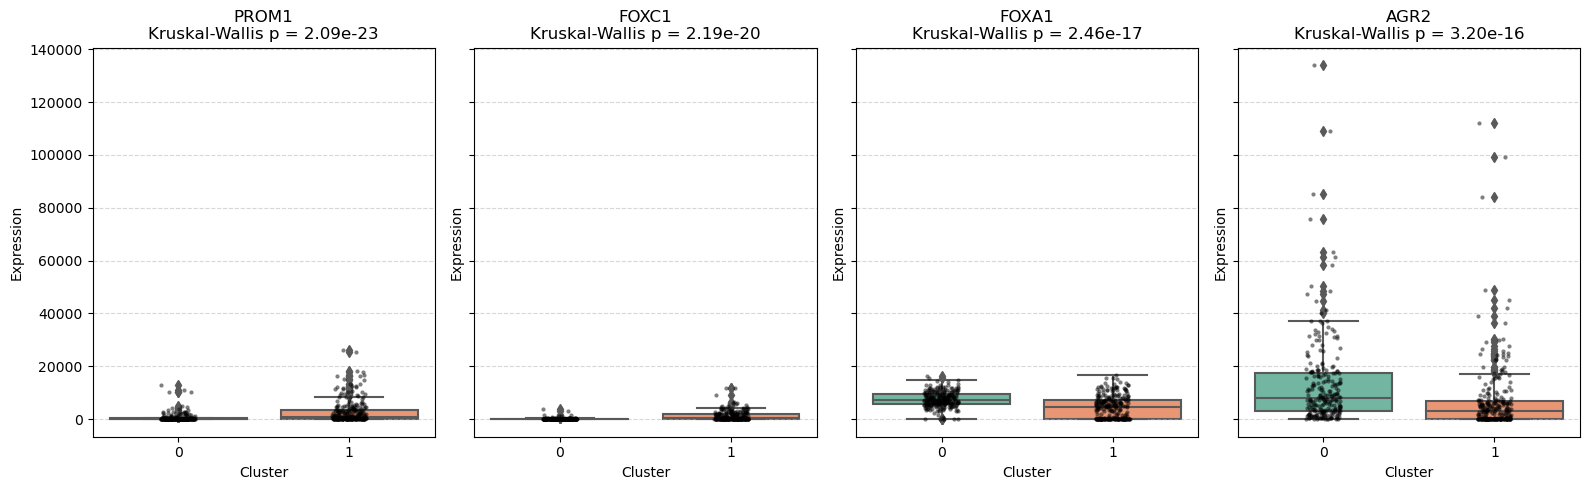

In [ ]:
top_genes = ["PROM1", "FOXC1", "FOXA1", "AGR2"]
top_n = len(top_genes)

# Prepare figure
fig, axes = plt.subplots(1, top_n, figsize=(4 * top_n, 5), sharey=True)

if top_n == 1:
    axes = [axes]  

# Loop over top genes
for i, gene in enumerate(top_genes):
    ax = axes[i]

    plot_df = pd.DataFrame({
        "Expression": rna_seq[gene],
        "Cluster": cluster_labels
    })

    # Kruskal-Wallis test for this gene
    groups = [plot_df.loc[plot_df["Cluster"] == c, "Expression"] for c in plot_df["Cluster"].unique()]
    stat, pval = kruskal(*groups)

    # Boxplot and swarmplot
    sns.boxplot(data=plot_df, x="Cluster", y="Expression", palette="Set2", ax=ax)
    sns.stripplot(data=plot_df, x="Cluster", y="Expression", color="black", alpha=0.5, size=3, ax=ax)

    # Title with gene name and p-value
    ax.set_title(f"{gene}\nKruskal-Wallis p = {pval:.2e}")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_xlabel("Cluster")

plt.tight_layout()
plt.show()
